## Importing Netflix data
Thanks to [Shubham](https://www.kaggle.com/shubham47/eda-on-netflix-prize/data) for this code snippit

In [4]:
from datetime import datetime
import os
import random
import matplotlib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [5]:
if not os.path.isfile('data.csv'):
    #read all txt file and store them in one big file
    data = open('NF_data.csv', mode='w')
    row = list()
    files = ['./combined_data_1.txt', './combined_data_2.txt',
            './combined_data_3.txt', './combined_data_4.txt']
    for file in files:
        print('reading ratings from {}...'.format(file))
        with open(file) as f:
            for line in f:
                del row[:]
                line = line.strip()
                if line.endswith(':'):
                    #all are rating
                    movid_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movid_id)
                    data.write(','.join(row))
                    data.write('\n')
        print('Done.\n')
    data.close()

reading ratings from ./combined_data_1.txt...
Done.

reading ratings from ./combined_data_2.txt...
Done.

reading ratings from ./combined_data_3.txt...
Done.

reading ratings from ./combined_data_4.txt...
Done.



In [6]:
print('creating the dataframe from data.csv file..')
df = pd.read_csv('NF_data.csv', sep=',', names=['movie','user','rating','date'])

df.date = pd.to_datetime(df.date)
print('Done.\n')

#arranging the rating according to time
print('sorting the dataframe by date..')
df.sort_values(by='date', inplace=True)
print('sorting done.')

creating the dataframe from data.csv file..
Done.

sorting the dataframe by date..
sorting done.


Checking for null values:

In [7]:
print('number of NaN values in our dataset:', sum(df.isnull().any()))

number of NaN values in our dataset: 0


Checking for duplicates:

In [8]:
dup = df.duplicated(['movie','user','rating'])
dups = sum(dup) #considering by column
print('there are {} duplicate ratings entries in the data.'.format(dups))

there are 0 duplicate ratings entries in the data.


Dataset summary:

In [9]:
print(f"\nTotal number of ratings: {df.shape[0]:,.0f}")
print(f'Total number of users: {len(np.unique(df.user)):,.0f}')
print(f'total number of movies: {len(np.unique(df.movie)):,.0f}')


Total number of ratings: 100,480,507
Total number of users: 480,189
total number of movies: 17,770


Merge in movie names:

In [10]:
movie_titles = pd.read_csv("./movie_titles.csv", sep=',', header=None, names=['movie_id', 'year_of_release', 'title'], verbose=True, index_col='movie_id', encoding='ISO-8859-1')

Tokenization took: 4.82 ms
Type conversion took: 27.29 ms
Parser memory cleanup took: 0.01 ms


In [11]:
df.head(1)

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11


In [12]:
movie_titles.head(1)

,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet


In [13]:
df = df.merge(movie_titles, left_on='movie', right_on='movie_id')

In [14]:
df.head()

,movie,user,rating,date,year_of_release,title
0,10341,510180,4,1999-11-11,1996.0,Ponette
1,10341,535765,4,2000-01-06,1996.0,Ponette
2,10341,1434685,5,2000-01-07,1996.0,Ponette
3,10341,1308236,3,2000-01-08,1996.0,Ponette
4,10341,1983971,3,2000-01-08,1996.0,Ponette


Netflix movies only

In [15]:
nfm = df.groupby(['movie', 'title', 'year_of_release'], as_index=False)['rating'].mean()

In [16]:
nfm.head()

,movie,title,year_of_release,rating
0,1,Dinosaur Planet,2003.0,3.749543
1,2,Isle of Man TT 2004 Review,2004.0,3.558621
2,3,Character,1997.0,3.641153
3,4,Paula Abdul's Get Up & Dance,1994.0,2.739437
4,5,The Rise and Fall of ECW,2004.0,3.919298


## Bringing in Anime Database 

In [17]:
anime = pd.read_csv("./anime.csv", sep=',', header=0, names=['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], verbose=True, encoding='ISO-8859-1')

Tokenization took: 9.30 ms
Type conversion took: 17.32 ms
Parser memory cleanup took: 0.01 ms


In [18]:
print('number of NaN values in our dataset:', sum(anime.isnull().any()))

number of NaN values in our dataset: 3


In [19]:
dup = anime.duplicated()
dups = sum(dup) #considering by column
print('there are {} duplicate ratings entries in the data.'.format(dups))

there are 0 duplicate ratings entries in the data.


In [20]:
print(f"\nTotal number of ratings: {anime.shape[0]:,.0f}")
print(f'Total number of movie/show ids: {len(np.unique(anime.anime_id)):,.0f}')
print(f'total number of movies/shows: {len(np.unique(anime.name)):,.0f}')


Total number of ratings: 12,294
Total number of movie/show ids: 12,294
total number of movies/shows: 12,292


In [21]:
anime = anime.drop_duplicates(subset=['name'], keep=False)

In [101]:
df2 = nfm.merge(anime, how='right', left_on='title', right_on='name', indicator=True, suffixes=['_nf', '_a'], validate='m:1')

df2[df2._merge=='right_only'].sort_values(by='rating_a', ascending=False)[0:10]

dummies=df2['genre'].str.get_dummies(sep=', ')

removal = ['Dementia', 'Ecchi', 'Josei', 'Hentai', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life', 'Yaoi', 'Yuri']
dummies = dummies.drop(removal, axis=1)
df2 = pd.concat([df2, dummies], axis=1)

In [102]:
df2._merge.value_counts()
df2['Netflix'] = 0
df2.loc[df2['_merge']=='both', 'Netflix'] = 1

In [106]:
df2.rating_a.describe()

count    12071.000000
mean         6.473737
std          1.026757
min          1.670000
25%          5.880000
50%          6.560000
75%          7.180000
max         10.000000
Name: rating_a, dtype: float64

In [26]:
nfm.shape

(17763, 4)

In [27]:
df2.Netflix.value_counts()

0    12111
1      191
Name: Netflix, dtype: int64

In [28]:
191/12111

0.015770786887953102

In [107]:
df2.to_csv('./df2.csv')

In [29]:
df4 = df.merge(anime, how='left', left_on='title', right_on='name', indicator=True, suffixes=['_nf', '_a'], validate='m:1')
df4._merge.value_counts()

left_only     99275640
both           1204867
right_only           0
Name: _merge, dtype: int64

In [30]:
1204867/99275640

0.012136582549354505

In [31]:
df4.groupby('_merge')['rating_nf'].mean()

_merge
left_only     3.604122
right_only         NaN
both          3.618122
Name: rating_nf, dtype: float64

In [33]:
user_mean = df4.groupby(['user'], as_index=False)['rating_nf'].mean()

In [34]:
user_mean.rename({'rating_nf':'user_mean'}, axis=1, inplace=True)
df4 = df4.merge(user_mean, on='user', validate='m:1')

In [35]:
df4['std_rating'] = df4['rating_nf'] - df4['user_mean']
df4.groupby('_merge')['std_rating'].mean()

_merge
left_only     0.000207
right_only         NaN
both         -0.017046
Name: std_rating, dtype: float64

In [36]:
df4.shape

(100480507, 16)

In [37]:
df4['anime'] = 0
df4.loc[df4['_merge']=='both', 'anime'] = 1

In [38]:
user_views = df4.groupby(['user'], as_index=False)['anime'].sum()
user_views.describe()

,user,anime
count,4.801890e+05,480189.000000
mean,1.323439e+06,2.509152
std,7.652116e+05,3.784915
min,6.000000e+00,0.000000
25%,6.591220e+05,0.000000
50%,1.322528e+06,1.000000
75%,1.986118e+06,3.000000
max,2.649429e+06,188.000000


In [40]:
df_date1 = df4.groupby(pd.Grouper(key="date", freq="M"))['anime'].sum()

In [41]:
df_date2 = df4.groupby(pd.Grouper(key="date", freq="M"))['anime'].count()

In [52]:
df_date = pd.concat([df_date1, df_date2], axis=1)

In [59]:
df_date.columns = ['anime_sum', 'monthly_sum']
df_date['anime_scaled'] = df_date.anime_sum / df_date.monthly_sum

In [92]:
df_date = df_date.reset_index()
df_date.to_csv('./df_date.csv')

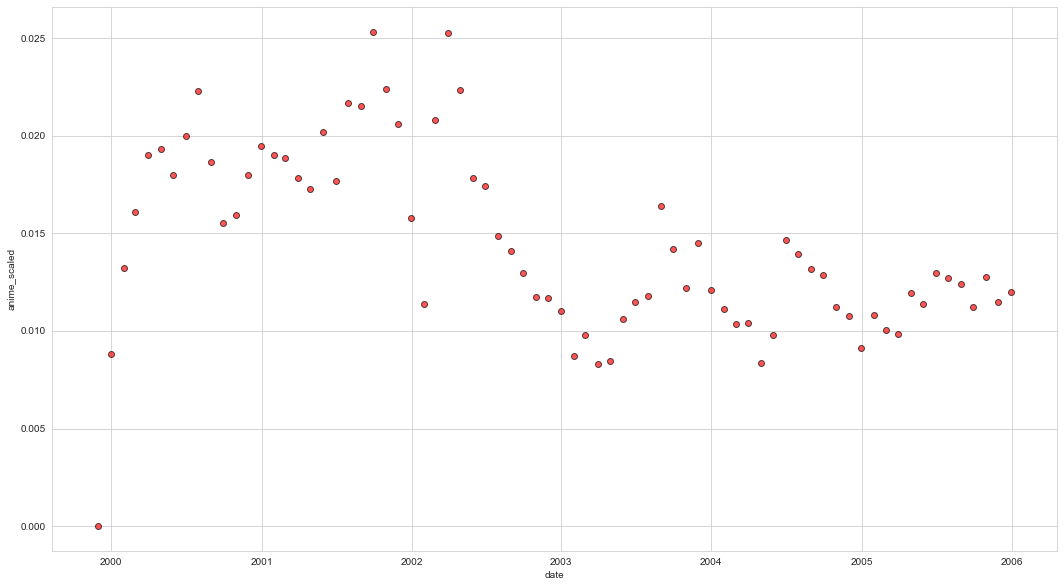

In [78]:
plt.figure(figsize=[18,10])
sns.regplot(data = df_date, x = 'date', y = 'anime_scaled', fit_reg = False,
             scatter_kws = {'alpha' : 2/3, 'edgecolor':'black',}, color='red');

In [100]:
df2.columns

Index(['movie', 'title', 'year_of_release', 'rating_nf', 'anime_id', 'name',
       'genre', 'type', 'episodes', 'rating_a', 'members', '_merge', 'Action',
       'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi',
       'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror', 'Josei',
       'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music',
       'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai',
       'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen',
       'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power',
       'Supernatural', 'Thriller', 'Vampire', 'Yaoi', 'Yuri', 'Netflix'],
      dtype='object')

Let's look at person-level ratings and how they align with the Anime database

In [114]:
# Dropping all non-anime movies
print(df4.shape)
df4.dropna(subset=['anime_id'], inplace=True)
print(df4.shape)

(100480507, 17)
(1204867, 17)


In [115]:
df4.rating_a.mean()

6.064281654861141

In [116]:
df4.rating_nf.mean()

3.6181221661809975

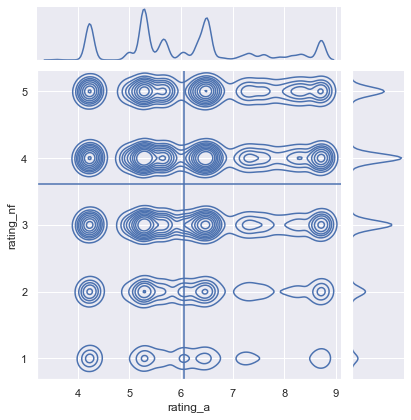

In [117]:
sns.set(color_codes=True)
plot = sns.jointplot(data=df4, x='rating_a', y='rating_nf', kind='kde')
plot.ax_joint.axhline(y=3.62)
plot.ax_joint.axvline(x=6.06)
plot.set_axis_labels(y='Netflix Rating', x='Anime Site Rating')

In [118]:
df4.rating_nf.value_counts()

4    419803
3    340021
5    274521
2    116954
1     53568
Name: rating_nf, dtype: int64

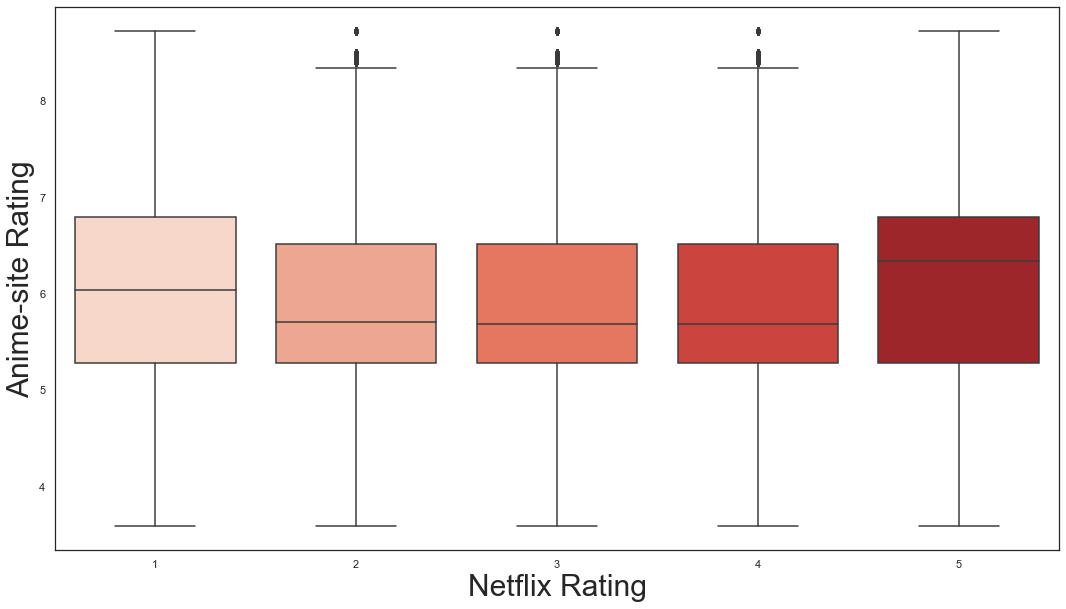

In [281]:
sns.set_style(style='white')
plt.figure(figsize=[18,10])
plot = sns.boxplot(x="rating_nf", y="rating_a", data=df4, palette="Reds")
plot.set_xlabel("Netflix Rating",fontsize=30)
plot.set_ylabel("Anime-site Rating",fontsize=30)
plt.savefig('boxplot.png');

In [137]:
print(f'Netflix rating 1: Mean Anime rating: {df4[df4.rating_nf==1].rating_a.mean():.2f}')
print(f'Netflix rating 2: Mean Anime rating: {df4[df4.rating_nf==2].rating_a.mean():.2f}')
print(f'Netflix rating 3: Mean Anime rating: {df4[df4.rating_nf==3].rating_a.mean():.2f}')
print(f'Netflix rating 4: Mean Anime rating: {df4[df4.rating_nf==4].rating_a.mean():.2f}')
print(f'Netflix rating 5: Mean Anime rating: {df4[df4.rating_nf==5].rating_a.mean():.2f}')

Netflix rating 1: Mean Anime rating: 6.05
Netflix rating 2: Mean Anime rating: 5.99
Netflix rating 3: Mean Anime rating: 6.00
Netflix rating 4: Mean Anime rating: 6.09
Netflix rating 5: Mean Anime rating: 6.14


In [138]:
df4.head()

,movie,user,rating_nf,date,year_of_release,title,anime_id,name,genre,type,episodes,rating_a,members,_merge,user_mean,std_rating,anime
44,6408,510180,4,2003-06-26,1987.0,Good Morning,8626.0,Good Morning,"Music, Slice of Life",Music,1,5.68,1381.0,both,3.351153,0.648847,1
55,607,510180,4,1999-12-11,1994.0,Speed,3799.0,Speed,Comedy,Movie,1,5.28,525.0,both,3.351153,0.648847,1
113,15466,510180,2,1999-12-11,1998.0,Firestorm,2382.0,Firestorm,"Action, Mecha, Military, Sci-Fi",TV,26,6.02,615.0,both,3.351153,-1.351153,1
204,7895,510180,2,2003-07-14,1992.0,Singles,2101.0,Singles,"Romance, Shoujo",OVA,1,5.32,161.0,both,3.351153,-1.351153,1
209,11701,510180,4,2000-11-05,1997.0,Contact,25985.0,Contact,"Comedy, Kids, Sci-Fi",Special,1,5.00,102.0,both,3.351153,0.648847,1


In [154]:
# Which movies have the most agreement? 
m_var = df4.groupby(['title'])['rating_nf'].agg(mov_sd='std').reset_index()
m_var.sort_values(by='mov_sd', inplace=True)

In [159]:
df2 = df2.merge(m_var, how='left', on='title')

In [160]:
df2.Netflix.value_counts()

0    12111
1      191
Name: Netflix, dtype: int64

In [161]:
df2[df2.Netflix==1].sort_values(by='mov_sd').head()

,movie,title,year_of_release,rating_nf,anime_id,name,genre,type,episodes,rating_a,...,School,Sci-Fi,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Netflix,mov_sd
200,15538.0,Fullmetal Alchemist,2004.0,4.605021,121,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",TV,51,8.33,...,0,0,0,0,0,0,0,0,1,0.765461
11857,14775.0,Vicious,2003.0,1.659574,4541,Vicious,Hentai,OVA,2,6.00,...,0,0,0,0,0,0,0,0,1,0.864212
104,2019.0,Samurai Champloo,2004.0,4.467500,205,Samurai Champloo,"Action, Adventure, Comedy, Historical, Samurai...",TV,26,8.50,...,0,0,0,0,0,0,0,0,1,0.886192
11799,13853.0,Dark Blue,2003.0,3.004885,12995,Dark Blue,Hentai,OVA,2,6.08,...,0,0,0,0,0,0,0,0,1,0.893404
7158,6408.0,Good Morning,1987.0,3.851776,8626,Good Morning,"Music, Slice of Life",Music,1,5.68,...,0,0,0,0,0,0,0,0,1,0.894887


In [171]:
df2.mov_sd.mean()

1.1376015166347413

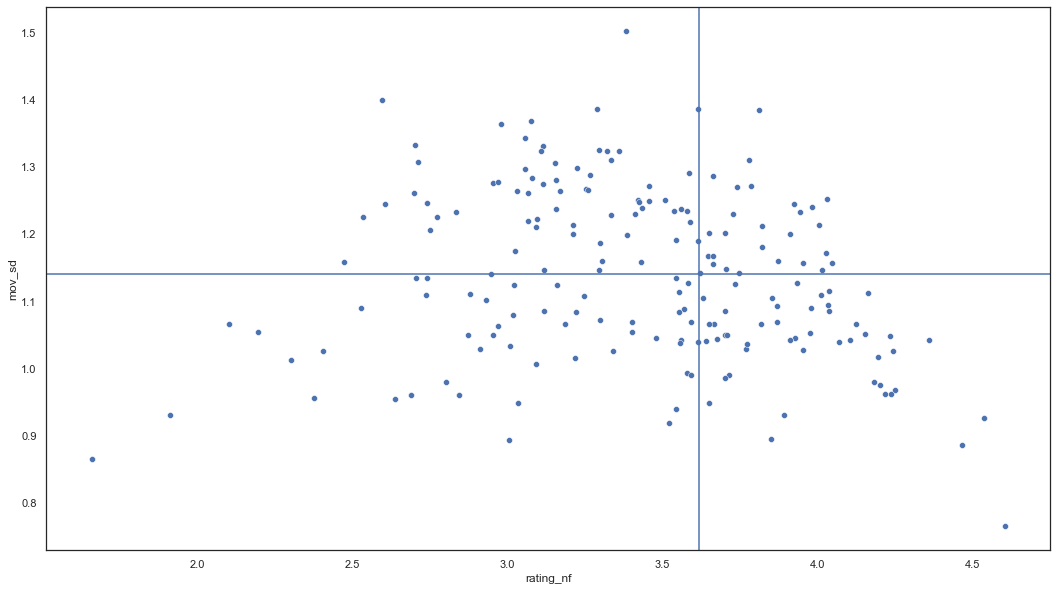

In [285]:
plt.figure(figsize=[18,10])
plot = sns.scatterplot(data=df2, x="rating_nf", y="mov_sd")
plot.axhline(y=1.14)
plot.axvline(x=3.62);
plt.savefig('rating_agreement.png');

In [254]:
for genre in ['Thriller', 'Vampire', 'Supernatural', 'Samurai', 'Horror', 'Parody', 'Police', 'Demons', 'Psychological', 'Military', 'Drama',  'Magic',
       'Mecha', 'Romance', 'Sci-Fi','Kids','Super Power']:
    print(f'{genre} represents roughly {100*df2[df2.Netflix==1][genre].mean():.1f}% of the Netflix Anime catelogue. They are {100*df2[(df2.hrha==1) & (df2.Netflix==1)][genre].mean():.2f}% of the hr/ha group with a ratio of {df2[(df2.hrha==1) & (df2.Netflix==1)][genre].mean() / df2[df2.Netflix==1][genre].mean():.2f}')

Thriller represents roughly 0.5% of the Netflix Anime catelogue. They are 1.64% of the hr/ha group with a ratio of 3.13
Vampire represents roughly 3.7% of the Netflix Anime catelogue. They are 9.84% of the hr/ha group with a ratio of 2.68
Supernatural represents roughly 7.9% of the Netflix Anime catelogue. They are 16.39% of the hr/ha group with a ratio of 2.09
Samurai represents roughly 1.6% of the Netflix Anime catelogue. They are 3.28% of the hr/ha group with a ratio of 2.09
Horror represents roughly 8.9% of the Netflix Anime catelogue. They are 18.03% of the hr/ha group with a ratio of 2.03
Parody represents roughly 3.7% of the Netflix Anime catelogue. They are 6.56% of the hr/ha group with a ratio of 1.79
Police represents roughly 9.4% of the Netflix Anime catelogue. They are 14.75% of the hr/ha group with a ratio of 1.57
Demons represents roughly 1.0% of the Netflix Anime catelogue. They are 1.64% of the hr/ha group with a ratio of 1.57
Psychological represents roughly 11.0% of t

So ... are genres that are disproportionately represented among movies/shows with the highest ratings and highest rating agreement. 

In [247]:
# Low rated & low agreement movies/shows:
df2['lrla']=0
df2.loc[(df2.rating_nf < df2.rating_nf.mean()) & (df2.mov_sd > df2.mov_sd.mean()), 'lrla'] = 1
print(f'Number (%) of lr/la movies: {df2[(df2.rating_nf < df2.rating_nf.mean()) & (df2.mov_sd > df2.mov_sd.mean())].shape[0]} ({5300/ (df2[df2.Netflix==1].shape[0]):.1f}%)')

for genre in ['Adventure', 'Comedy', 'Fantasy', 'Kids', 'Martial Arts', 'Music', 'Parody','School']:
    print(f'{genre} represents roughly {100*df2[df2.Netflix==1][genre].mean():.1f}% of the Netflix Anime catelogue. They are {100*df2[(df2.lrla==1) & (df2.Netflix==1)][genre].mean():.2f}% of the hr/ha group with a ratio of {df2[(df2.lrla==1) & (df2.Netflix==1)][genre].mean() / df2[df2.Netflix==1][genre].mean():.2f}')

Number (%) of lr/la movies: 53 (27.7%)
Adventure represents roughly 30.9% of the Netflix Anime catelogue. They are 37.74% of the hr/ha group with a ratio of 1.22
Comedy represents roughly 32.5% of the Netflix Anime catelogue. They are 33.96% of the hr/ha group with a ratio of 1.05
Fantasy represents roughly 14.1% of the Netflix Anime catelogue. They are 15.09% of the hr/ha group with a ratio of 1.07
Kids represents roughly 1.6% of the Netflix Anime catelogue. They are 1.89% of the hr/ha group with a ratio of 1.20
Martial Arts represents roughly 3.1% of the Netflix Anime catelogue. They are 5.66% of the hr/ha group with a ratio of 1.80
Music represents roughly 6.8% of the Netflix Anime catelogue. They are 9.43% of the hr/ha group with a ratio of 1.39
Parody represents roughly 3.7% of the Netflix Anime catelogue. They are 3.77% of the hr/ha group with a ratio of 1.03
School represents roughly 4.2% of the Netflix Anime catelogue. They are 5.66% of the hr/ha group with a ratio of 1.35


The Adventure genre appears over-represented among the lr/la group

In [256]:
# Low rated & high agreement movies/shows:
df2['lrha']=0
df2.loc[(df2.rating_nf < df2.rating_nf.mean()) & (df2.mov_sd < df2.mov_sd.mean()), 'lrha'] = 1
print(f'Number (%) of lr/ha movies: {df2[(df2.rating_nf < df2.rating_nf.mean()) & (df2.mov_sd < df2.mov_sd.mean())].shape[0]} ({3700/ (df2[df2.Netflix==1].shape[0]):.1f}%)')

for genre in ['Sports','Historical', 'Samurai', 'Music', 'Super Power']:
    print(f'{genre} represents roughly {100*df2[df2.Netflix==1][genre].mean():.1f}% of the Netflix Anime catelogue. They are {100*df2[(df2.lrha==1) & (df2.Netflix==1)][genre].mean():.2f}% of the hr/ha group with a ratio of {df2[(df2.lrha==1) & (df2.Netflix==1)][genre].mean() / df2[df2.Netflix==1][genre].mean():.2f}')

Number (%) of lr/ha movies: 37 (19.4%)
Sports represents roughly 2.1% of the Netflix Anime catelogue. They are 8.11% of the hr/ha group with a ratio of 3.87
Historical represents roughly 3.1% of the Netflix Anime catelogue. They are 10.81% of the hr/ha group with a ratio of 3.44
Samurai represents roughly 1.6% of the Netflix Anime catelogue. They are 2.70% of the hr/ha group with a ratio of 1.72
Music represents roughly 6.8% of the Netflix Anime catelogue. They are 10.81% of the hr/ha group with a ratio of 1.59
Super Power represents roughly 4.7% of the Netflix Anime catelogue. They are 5.41% of the hr/ha group with a ratio of 1.15


In [257]:
Recommendation: Procure more movies/shows with horror, vampire, thriller, supernatural themes.
Avoid movies/shows with sport, historical, and samurai themes. 

(12302, 48)

In [260]:
df2[(df2.Netflix==0) & (df2.Horror==1)].sort_values(by='rating_a', ascending=False)[0:10]

,movie,title,year_of_release,rating_nf,anime_id,name,genre,type,episodes,rating_a,...,Sports,Super Power,Supernatural,Thriller,Vampire,Netflix,mov_sd,hrha,lrla,lrha
66,NaN,NaN,NaN,NaN,777,Hellsing Ultimate,"Action, Horror, Military, Seinen, Supernatural...",OVA,10,8.59,...,0,0,1,0,1,0,NaN,0,0,0
67,NaN,NaN,NaN,NaN,22535,Kiseijuu: Sei no Kakuritsu,"Action, Drama, Horror, Psychological, Sci-Fi, ...",TV,24,8.59,...,0,0,0,0,0,0,NaN,0,0,0
91,NaN,NaN,NaN,NaN,13125,Shinsekai yori,"Drama, Horror, Mystery, Sci-Fi, Supernatural",TV,25,8.53,...,0,0,1,0,0,0,NaN,0,0,0
109,NaN,NaN,NaN,NaN,2246,Mononoke,"Demons, Fantasy, Historical, Horror, Mystery, ...",TV,12,8.49,...,0,0,1,0,0,0,NaN,0,0,0
198,NaN,NaN,NaN,NaN,12115,Berserk: Ougon Jidai-hen III - Kourin,"Action, Adventure, Demons, Drama, Fantasy, Hor...",Movie,1,8.33,...,0,0,1,0,0,0,NaN,0,0,0
334,NaN,NaN,NaN,NaN,934,Higurashi no Naku Koro ni,"Horror, Mystery, Psychological, Supernatural, ...",TV,26,8.17,...,0,0,1,1,0,0,NaN,0,0,0
365,NaN,NaN,NaN,NaN,1943,Paprika,"Fantasy, Horror, Mystery, Psychological, Sci-F...",Movie,1,8.15,...,0,0,0,1,0,0,NaN,0,0,0
9978,NaN,NaN,NaN,NaN,32660,Petit Petit Muse,"Cars, Horror, Kids",TV,26,8.14,...,0,0,0,0,0,0,NaN,0,0,0
388,NaN,NaN,NaN,NaN,33253,Ajin 2nd Season,"Action, Horror, Mystery, Seinen, Supernatural",TV,13,8.12,...,0,0,1,0,0,0,NaN,0,0,0
412,NaN,NaN,NaN,NaN,34103,Danganronpa 3: The End of Kibougamine Gakuen -...,"Action, Horror, Mystery, Psychological",Special,1,8.10,...,0,0,0,0,0,0,NaN,0,0,0


In [263]:
df2.to_csv('./df2.csv')

In [264]:
df2.type.value_counts()

TV         3787
OVA        3313
Movie      2355
Special    1676
ONA         658
Music       488
Name: type, dtype: int64

In [265]:
df2[df2.Netflix==1].type.value_counts()

TV         79
Movie      52
OVA        47
Music       6
ONA         5
Special     2
Name: type, dtype: int64

In [266]:
print('creating the dataframe from data.csv file..')
df = pd.read_csv('Anime_Top10000.csv', sep=',')

creating the dataframe from data.csv file..


In [284]:
pd.set_option('display.max_colwidth', None)
df[df.Anime_Name == "Fruits Basket"]

,Anime_Name,Anime_Episodes,Anime_Air_Years,Anime_Rating,Synopsis
1057,Fruits Basket,TV (26 eps),Jul 2001 - Dec 2001,7.69,"After the accident in which she lost her mother, 16-year-old Tooru moves in with her grandfather, but due to his home being renovated, is unable to continue living with him. Claiming she will find someone to stay with but also fearing the criticism of her family and not wanting to burden any of her friends, Tooru resorts to secretly living on her own in a tent in the woods.\n\r\nOne night on her way back from work, she finds her tent buried underneath a landslide. Yuki Souma, the ""prince"" of her school, and his cousin Shigure Souma, a famous author, stumble across Tooru's situation and invite her to stay with them until her grandfather's home renovations are complete.\n\r\nUpon arriving at the Souma house, Tooru discovers their secret: if a Souma is hugged by someone of the opposite gender, they temporarily transform into one of the animals of the zodiac! However, this strange phenomenon is no laughing matter; rather, it is a terrible curse that holds a dark history. As she continues her journey, meeting more members of the zodiac family, will Tooru's kindhearted yet resilient nature be enough to prepare her for what lies behind the Souma household's doors?\n\r\n[Written by MAL Rewrite]"


In [286]:
df

,Anime_Name,Anime_Episodes,Anime_Air_Years,Anime_Rating,Synopsis
0,Fullmetal Alchemist: Brotherhood,TV (64 eps),Apr 2009 - Jul 2010,9.18,"""In order for something to be obtained, something of equal value must be lost.""\n\r\nAlchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist.\n\r\nThree years of searching later, the brothers seek the Philosopher's Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes Hughes on their side, the brothers find themselves caught up in a nationwide conspiracy that leads them not only to the true nature of the elusive Philosopher's Stone, but their country's murky history as well. In between finding a serial killer and racing against time, Edward and Alphonse must ask themselves if what they are doing will make them human again... or take away their humanity.\n\r\n[Written by MAL Rewrite]"
1,Shingeki no Kyojin Season 3 Part 2,TV (10 eps),Apr 2019 - Jul 2019,9.11,"Seeking to restore humanity's diminishing hope, the Survey Corps embark on a mission to retake Wall Maria, where the battle against the merciless ""Titans"" takes the stage once again.\n\r\nReturning to the tattered Shiganshina District that was once his home, Eren Yeager and the Corps find the town oddly unoccupied by Titans. Even after the outer gate is plugged, they strangely encounter no opposition. The mission progresses smoothly until Armin Arlert, highly suspicious of the enemy's absence, discovers distressing signs of a potential scheme against them. \n\nShingeki no Kyojin Season 3 Part 2 follows Eren as he vows to take back everything that was once his. Alongside him, the Survey Corps strive—through countless sacrifices—to carve a path towards victory and uncover the secrets locked away in the Yeager family's basement.\n\r\n[Written by MAL Rewrite]"
2,Steins;Gate,TV (24 eps),Apr 2011 - Sep 2011,9.11,"The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective ""future gadgets"" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed ""Daru."" The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the ""Phone Microwave,"" which performs the strange function of morphing bananas into piles of green gel.\n\r\nThough miraculous in itself, the phenomenon doesn't provide anything concrete in Okabe's search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history.\n\r\nAdapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory and practicality. Forced across the diverging threads of past and present, Okabe must shoulder the burdens that come with holding the key to the realm of time.\n\r\n[Written by MAL Rewrite]"
3,Gintama°,TV (51 eps),Apr 2015 - Mar 2016,9.09,"Gintoki, Shinpachi, and Kagura return as the fun-loving but broke members of the Yorozuya team! Living in an alternate-reality Edo, where swords are prohibited and alien overlords have